In [1]:
# Descomentar para actualizar librerias
# Si se actualiza alguna libreria hay que reiniciar el notebook
!pip install plotly --upgrade --user --quiet
!pip install pandas --upgrade --user --quiet
!pip install numpy --upgrade --user --quiet
!pip install scipy --upgrade --user --quiet
!pip install statsmodels --upgrade --user --quiet
!pip install scikit-learn --upgrade --user --quiet
!pip install missingno --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# APA - Ejercicio 1 - ¿Qué edad tienes?

## Load Inicial

En este problema trabajaré con el conjunto de datos Stroke Prediction Dataset, el cual contiene una descripcion de un conjunto de personas a partir de características demográficas, médicas y de hábitos. Esto será utilizado para predecir diferentes hechos a partir de este conjunto, principalmente la edad de las personas a partir de sus características personales.

La selección de este conjunto la obtendré utilizando la funcion load_stroke de la libreria apafib.

También cargaremos todos los imports necesarios para hacer todo el estudio y trabajo sobre nuestros datos.

In [34]:
from sklearn import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as msno


from sklearn import set_config

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

from mpl_toolkits.mplot3d import Axes3D

#from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)


set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)



In [28]:
from apafib import load_stroke
spd = load_stroke()

#hacemos un head para ver un poco como es el formato de la tabla inicialmente
spd.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,62602,Female,49.0,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


## Apartado A

### Eliminar variables sin sentido

Una vez cargado hemos de eliminar las variables que no tiene sentido utilizar por aportar poco valor al objetivo de nuestro estudio, a priori no podriamos discernir entre claros elementos que no aporten mucho al resultado final más allá de evidentemente el id el cual no nos aporta nada sobre la informacion del individuo al que nos referimos.

El genero tampoco parece aportar demasiado a discernir en la edad de un individuo (tal vez si quisieramos ver probabilidad de otros aspectos de salud si pero en este caso no aporta nada).

Existen variables de estilo de vida que pueden parecer poco relevantes como el tipo de trabajo o tipo de residencia pero puesto que estas pueden estar relacionas con la edad a priori las mantendré.

Tras eliminar las que de momento se consideran poco relevante comodamente queda nuestra variable objetivo como la primera columna.

In [5]:
spd.drop(columns=['id', 'gender'], inplace=True)

### Dividir el conjunto en entrenamiento y test

Ahora procedo a dividir el conjunto de datos en entrenamiento y test con ratio de (70%/30%).

In [6]:
spd_train, spd_test = train_test_split(spd, test_size=0.3, random_state=0)

spd_train.shape, spd_test.shape

((1972, 10), (846, 10))

### Exploración rápida de las variables

Observaremos rápidamente un poco las variables del conjunto de entrenamiento mediante visualizacion para familiarizarnos con la distribución de las mismas.

Nos centraremos en observar la relaciond e variables con la variable objetivo, asimismo mirando de sacar alguna observacion que pueda resultar de interes para las posteriores fases del proyecto.

De primeras el tipo de residencia no promete mucho, lo conservé en caso de que por algún casual se viese reflejado el efecto de la huida hacia las ciudades y la desrtizacion de la zona rural pudiendo tener un rol en determinar mejor la edad peró están distribuidos de forma bastante igualitaria.

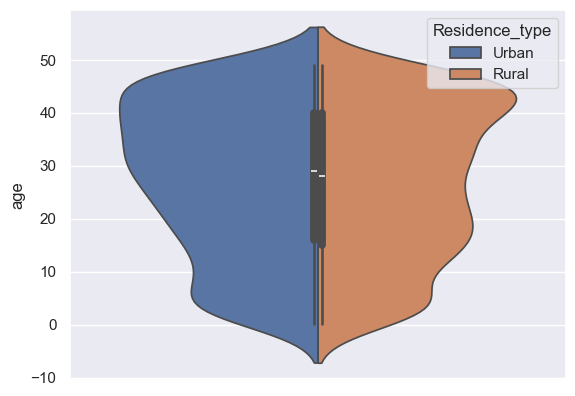

In [19]:
sns.violinplot(data=spd_train, y="age", hue="Residence_type", split=True);

Los siguentes plots nos hacen ver que a priori las enfermedades o aspectos de estilo de vida que suceden de forma mas tardía (casarse por ejemplo) tienen un claro valor para determinar como de mayor puede ser alguién

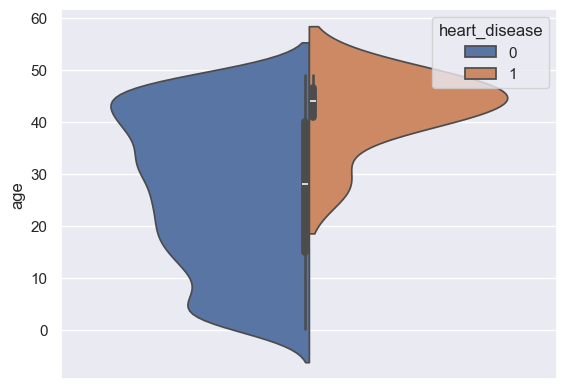

In [21]:
sns.violinplot(data=spd_train, y="age", hue="heart_disease", split=True);

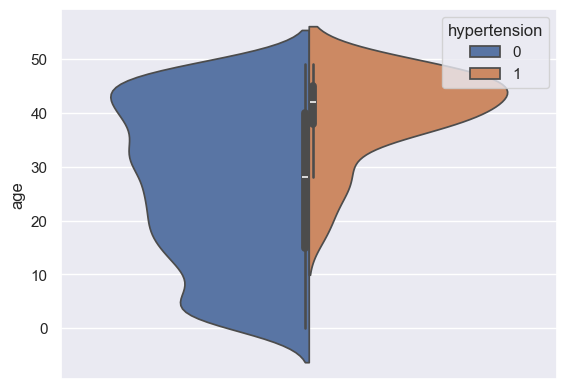

In [20]:
sns.violinplot(data=spd_train, y="age", hue="hypertension", split=True);

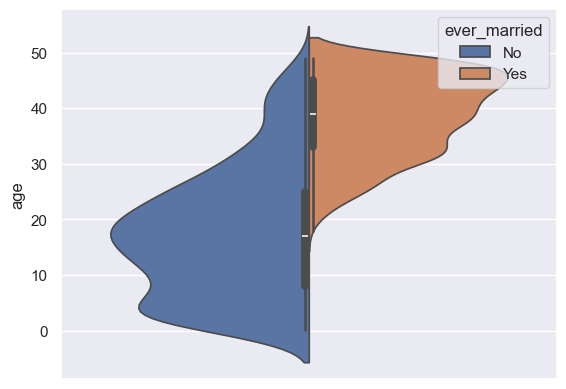

In [25]:
sns.violinplot(data=spd_train, y="age", hue="ever_married", split=True);

Por otro lado, en el violin plot de fumar no parece que podamos decir mucho de el, pues no han preguntado a menores y la distribución entre los tres grupos de fumadores en adultos es bastante unifmorme sin seguir patrones claros. Más o menos lo mismo nos pasa con el tipo de trabajom el cual evidentemente para niños se pone que estos no trabajan y entre los adultos se ve poca correlación, con los adultos que trabajan en el govierno o de autónomos se ve un crecimiento hasta la adultez mas tardía.

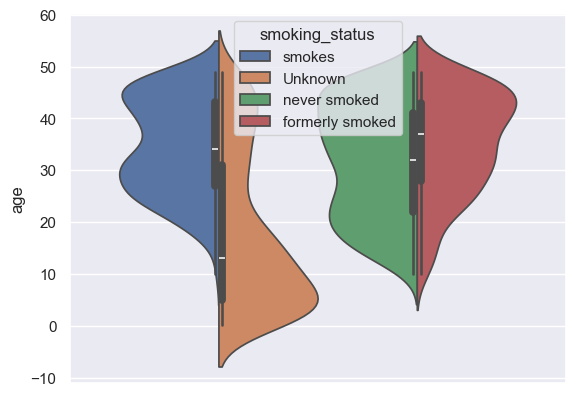

In [22]:
sns.violinplot(data=spd_train, y="age", hue="smoking_status", split=True);

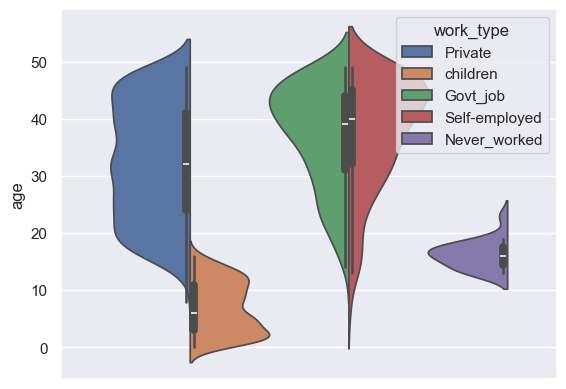

In [30]:
sns.violinplot(data=spd_train, y="age", hue="work_type", split=True);

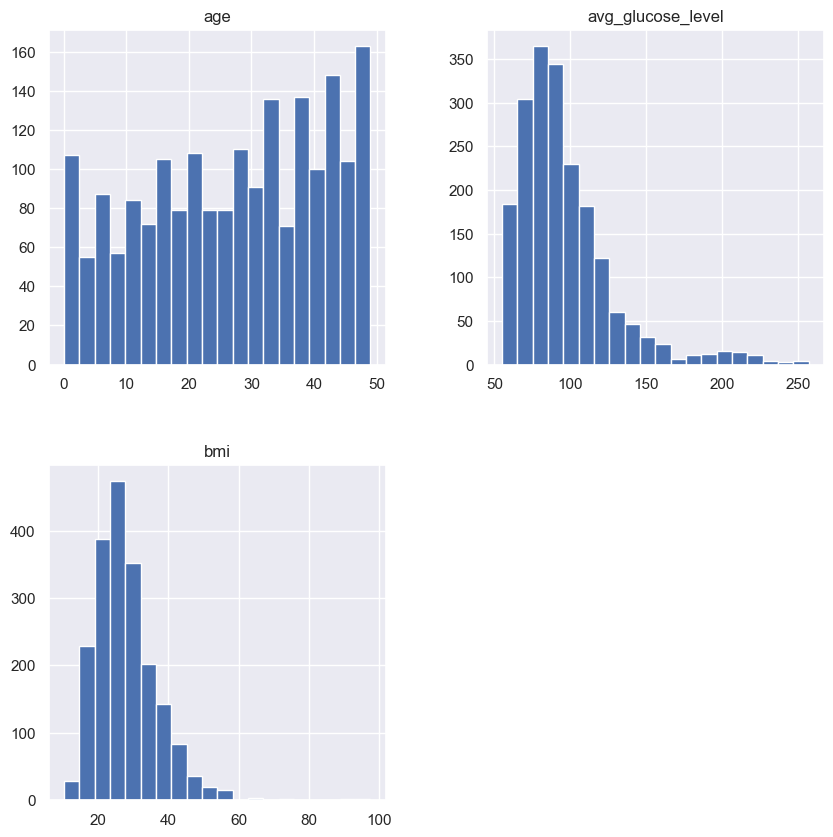

In [9]:
spd_train.loc[:,['age', 'avg_glucose_level', 'bmi']].hist(bins=20, figsize=(10,10));

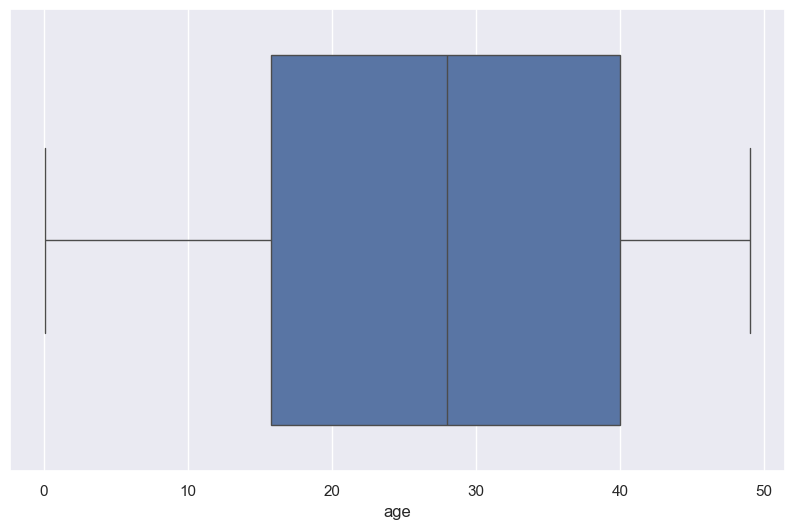

In [10]:
plt.figure(figsize=(10,6));
sns.boxplot(data=spd_train, x="age");

In [11]:
spd_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,846.0,NaN,NaN,NaN,26.047,14.411,0.24,14.0,27.0,39.0,49.0
hypertension,846.0,NaN,NaN,NaN,0.022,0.148,0.0,0.0,0.0,0.0,1.0
heart_disease,846.0,NaN,NaN,NaN,0.006,0.077,0.0,0.0,0.0,0.0,1.0
ever_married,846,2,No,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,846,5,Private,485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,846,2,Urban,431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,846.0,NaN,NaN,NaN,96.288,32.809,55.25,75.855,89.23,107.453,267.76
bmi,846.0,NaN,NaN,NaN,26.968,7.983,13.3,21.2,25.5,31.675,78.0
smoking_status,846,4,Unknown,336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stroke,846.0,NaN,NaN,NaN,0.008,0.091,0.0,0.0,0.0,0.0,1.0


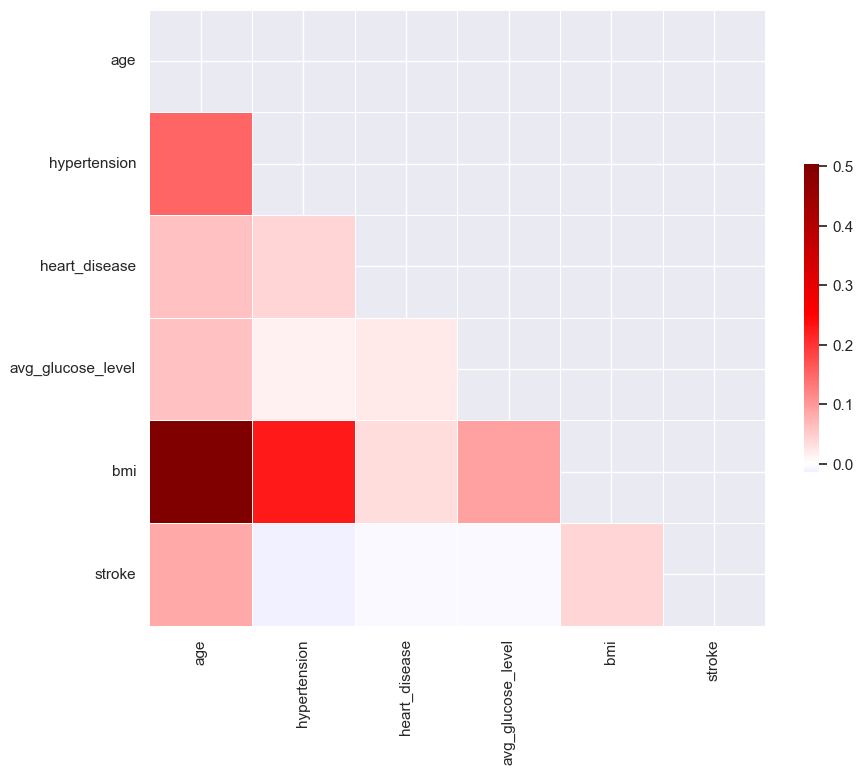

In [18]:
corr = spd_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

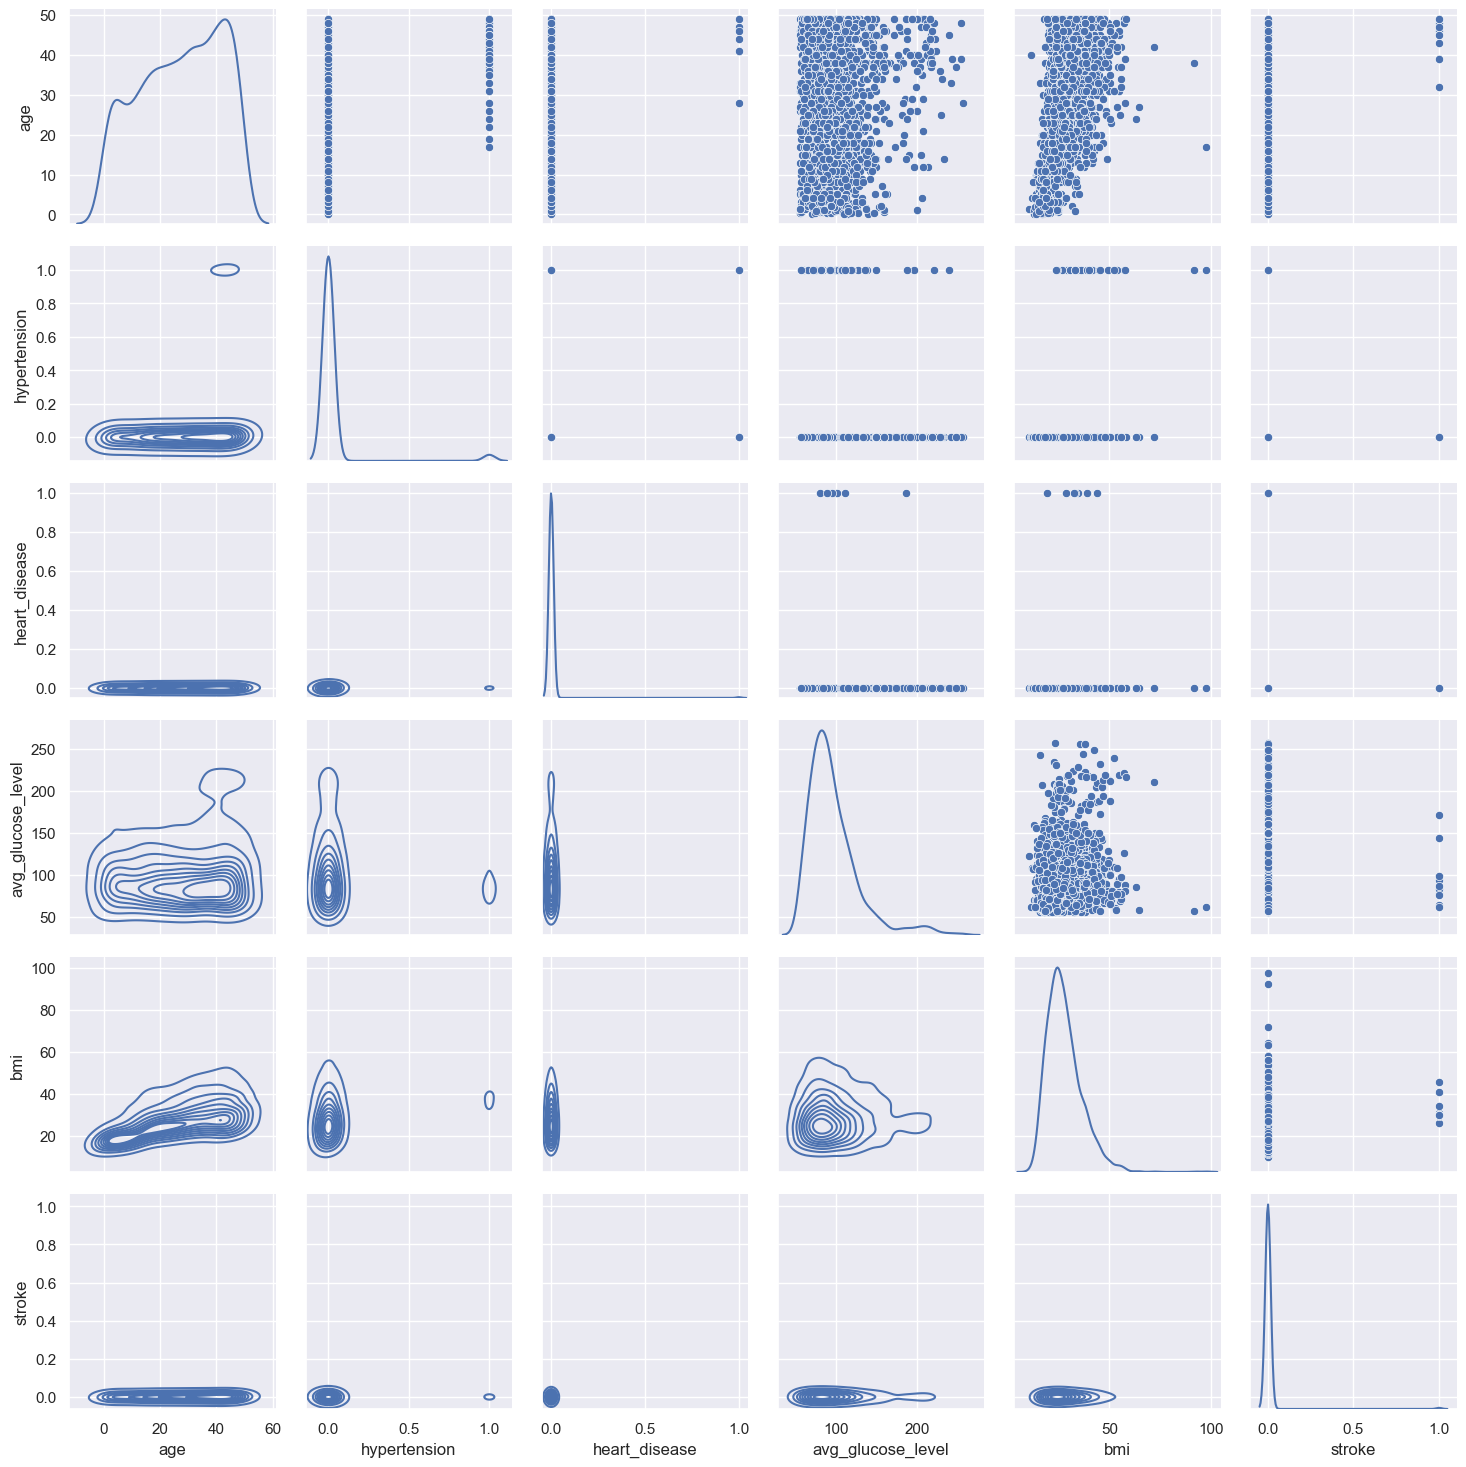

In [16]:
g = sns.PairGrid(spd_train, diag_sharey=False)
g.map_upper(sns.scatterplot);
g.map_lower(sns.kdeplot);
g.map_diag(sns.kdeplot);

### Transformación de las variables para ajustar al modelo de regresión

Ahora transformaremos las variables que no sean númericas en estas para poder procesarlas después

Las variables que hemos de cambiar són las residence_type, ever_married, work_type y smoking_status. Las dos primeras son booleanas así que basta con codificarlas con 1 o 0. El resto las convertiremos en sus propias variables binarias eliminando las que sean linealmente dependientes unas de otras (a veces pasa al descomponer variables así)

In [32]:
spd_train['Residence_type'] = spd_train['Residence_type'].astype('category').cat.codes
spd_train['ever_married'] = spd_train['ever_married'].astype('category').cat.codes
dummies1 = pd.get_dummies(spd_train['work_type'], drop_first=True, prefix=' work_type', prefix_sep='_')
dummies2 = pd.get_dummies(spd_train['smoking_status'], drop_first=True, prefix='smoking_status', prefix_sep='_')
spd_train = pd.concat([spd_train,dummies1], axis=1)
spd_train.drop(columns=['work_type'], inplace=True)
spd_train = pd.concat([spd_train,dummies2], axis=1)
spd_train.drop(columns=['smoking_status'], inplace=True)
spd_train.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
206,29.0,0,0,0,1,207.58,22.8,0,False,True,False,False,False,False,True
2037,2.0,0,0,0,1,105.75,19.8,0,False,False,False,True,False,False,False
1824,42.0,0,0,1,0,80.00,27.5,0,False,True,False,False,False,True,False
2029,39.0,0,0,1,1,78.24,28.6,0,False,True,False,False,False,False,False
2441,42.0,0,0,1,0,67.97,23.8,0,False,False,False,False,False,False,False


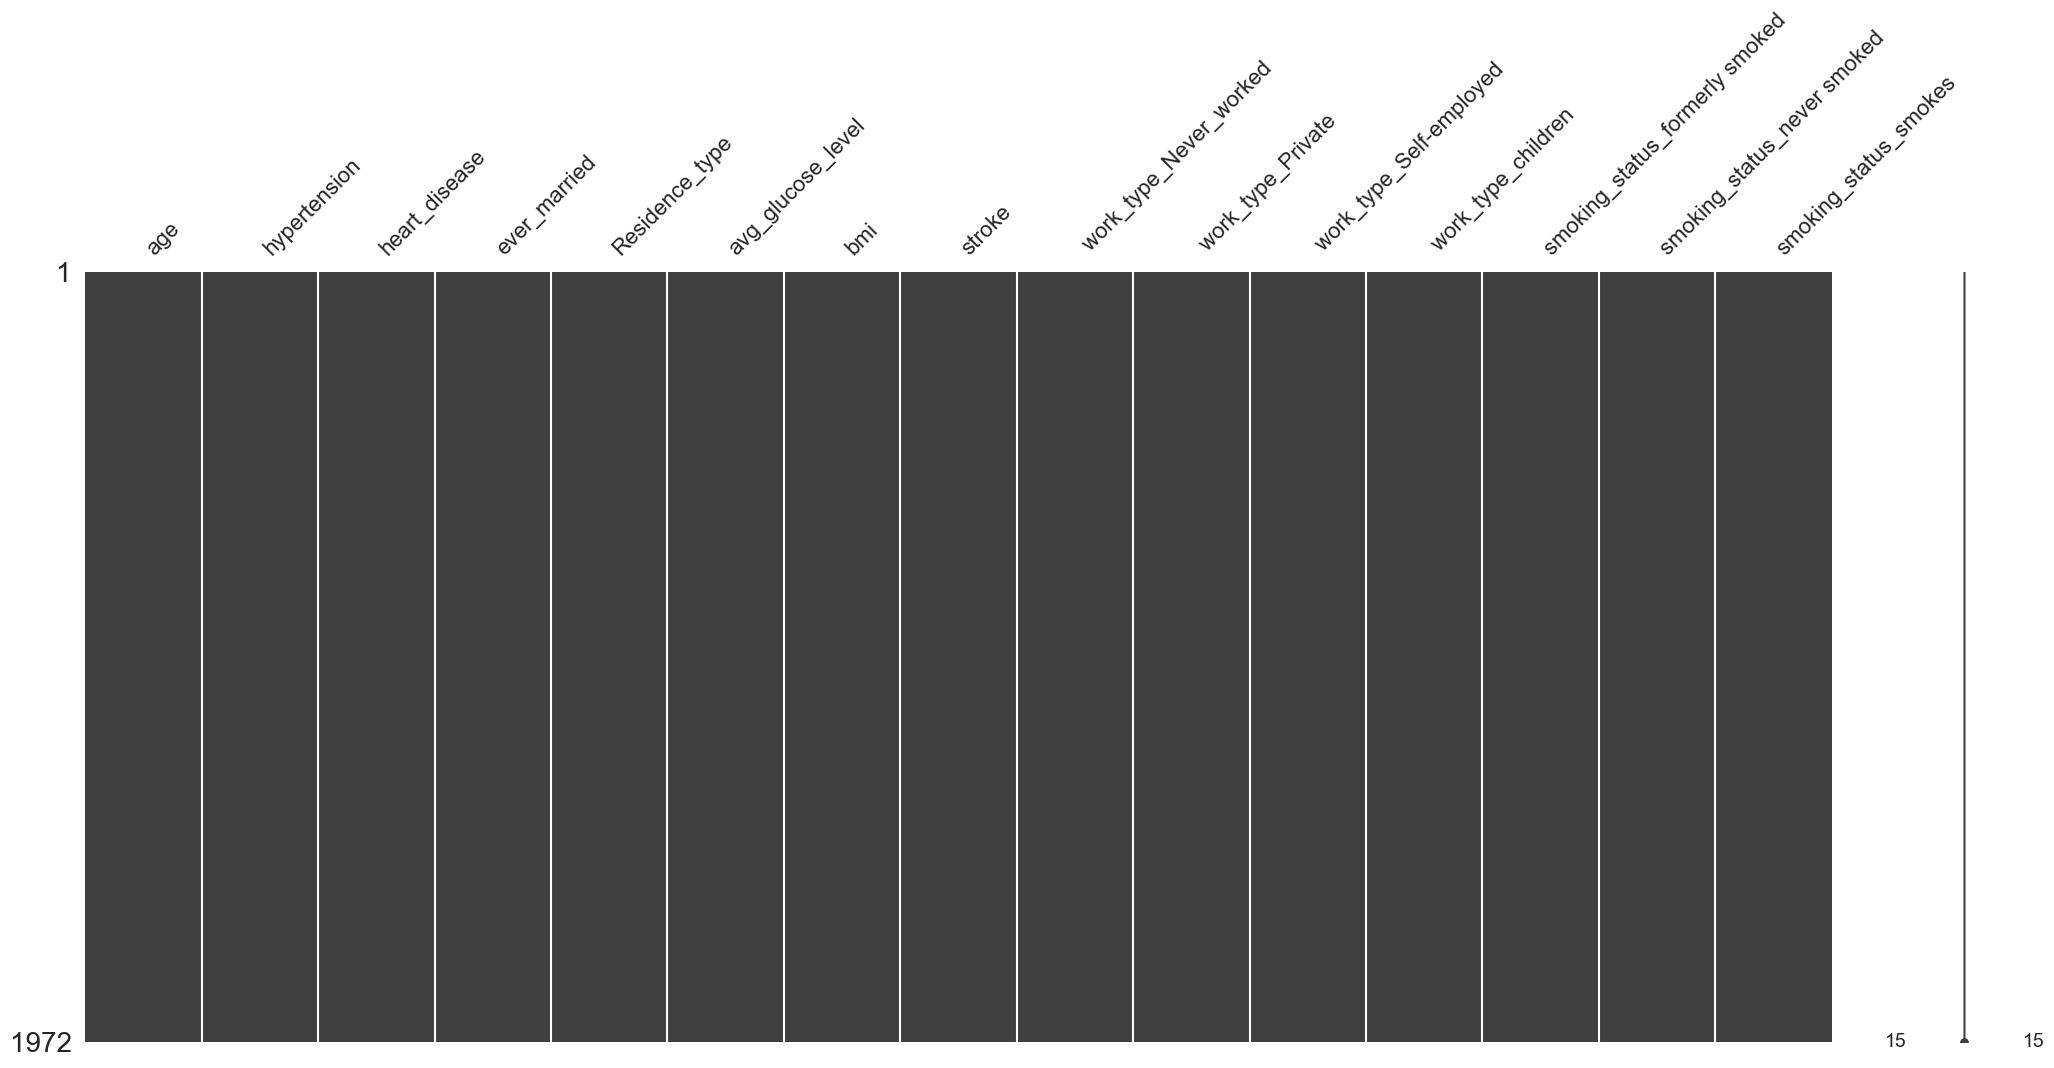

In [35]:
msno.matrix(spd_train);

In [36]:

spd_test['Residence_type'] = spd_test['Residence_type'].astype('category').cat.codes
spd_test['ever_married'] = spd_test['ever_married'].astype('category').cat.codes
dummies1 = pd.get_dummies(spd_test['work_type'], drop_first=True, prefix=' work_type', prefix_sep='_')
dummies2 = pd.get_dummies(spd_test['smoking_status'], drop_first=True, prefix='smoking_status', prefix_sep='_')
spd_test = pd.concat([spd_test,dummies1], axis=1)
spd_test.drop(columns=['work_type'], inplace=True)
spd_test = pd.concat([spd_test,dummies2], axis=1)
spd_test.drop(columns=['smoking_status'], inplace=True)
spd_test.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2714,38.0,0,0,1,0,73.76,37.4,0,False,True,False,False,False,True,False
333,23.0,0,0,0,1,79.39,27.6,0,False,True,False,False,False,True,False
70,23.0,0,0,0,1,99.92,25.8,0,False,True,False,False,False,True,False
569,23.0,0,0,0,0,90.84,31.6,0,False,True,False,False,False,True,False
118,12.0,0,0,0,0,75.22,20.9,0,False,False,False,True,False,False,False


## Apartado B

### PCA

Una vez hemos preprocesado las variables y hemos hecho una exploración que nos permite entender un poco por donde van los tiros con la correlacion entre nuestra variable objetivo y el resto de vairbales